# RAMP on predicting cyclist traffic in Paris

Authors: *Alicia González and Nazila Sharifi Amila*.



## Introduction

The original dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
 Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

First, we import the libraries needed for our project.

In [1]:
pip install holidays

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import holidays
import xgboost

/Users/aligonzalezlobo/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/aligonzalezlobo/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/aligonzalezlobo/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/aligonzalezlobo/opt/anaconda3/lib/python3.8/site-packages/dask/da

# Loading the data with pandas

First, download the data files,
 - [train.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/train.parquet)
 - [test.parquet](https://github.com/rth/bike_counters/releases/download/v0.1.0/test.parquet)

and put them to into the data folder.

In [3]:
data = pd.read_parquet(Path("data") / "train.parquet")

In [4]:
# lets check our data

data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585


In [5]:
new_data3 = data.drop(['counter_id','site_id', 'counter_installation_date', 'counter_technical_id', 'latitude', 'longitude', 'bike_count'], axis=1)

new_data3.head()

,counter_name,site_name,date,log_bike_count
48321,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000
48324,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147
48327,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000
48330,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438
48333,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585


In [6]:
# lets also check the information of our data (number of samples, type of the different variables)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 48321 to 928462
Data columns (total 11 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
dtypes: category(4), datetime64[ns](2), float64(4), i

In [7]:
# checkin the shape

data.shape

(455163, 11)

# Visualizing the data


Let's visualize the data, starting from the spatial distribution of counters on the map

In [8]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

<AxesSubplot: xlabel='date'>

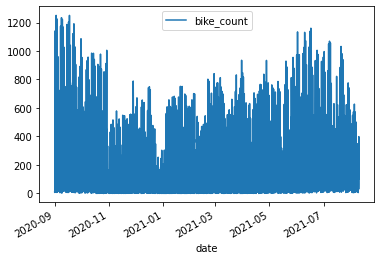

In [9]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].plot(x="date", y="bike_count")

<AxesSubplot: xlabel='date'>

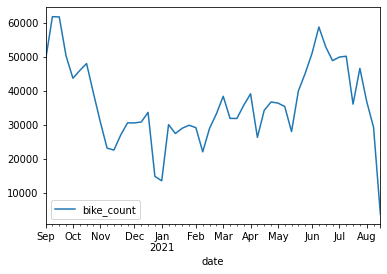

In [10]:
mask = data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N"

data[mask].groupby(pd.Grouper(freq="1w", key="date"))[["bike_count"]].sum().plot()

<AxesSubplot: xlabel='date'>

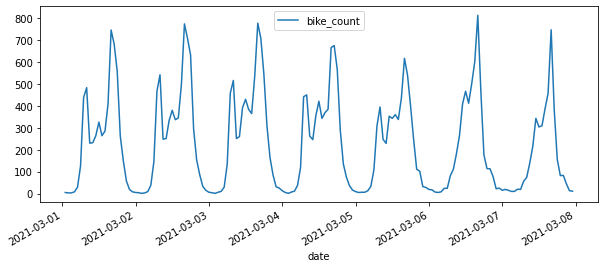

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))

mask = (
    (data["counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data["date"] > pd.to_datetime("2021/03/01"))
    & (data["date"] < pd.to_datetime("2021/03/08"))
)

data[mask].plot(x="date", y="bike_count", ax=ax)

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

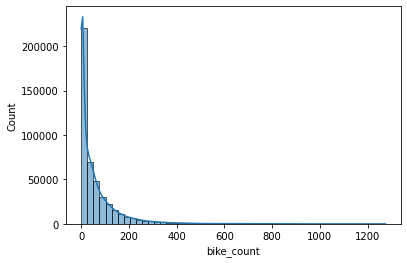

In [12]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

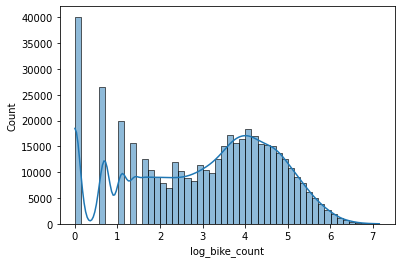

In [13]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

## Feature extraction

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field, 

In [14]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour

    # Finally we can drop the original columns from the dataframe
    return X.drop(columns=["date"])

date_encoder = FunctionTransformer(_encode_dates, validate=False)
date_encoder.fit_transform(data[["date"]]).head()

# Loading more data

We are now going to download another database we have found that will provide us with information about the number of heavy vehicles in Paris at different times of the day. We download the data file,

- [Comptage multimodal (Vélo, Trottinette, 2RM, VL, PL, Autobus-car) - Comptages] (https://opendata.paris.fr/explore/dataset/comptage-multimodal-comptages/information/?disjunctive.label&disjunctive.mode&disjunctive.voie&disjunctive.sens&disjunctive.trajectoire)

By adding this database, we think we will be able to get a better prediction of bike traffic in Paris on different dates. With the analysis of the database, we will be able to see if there is any correlation between bicycle traffic and heavy vehicle traffic. 

In [15]:
external_data = pd.read_csv("data/external_data.csv",sep=';')

In [16]:
# lets check our data

external_data.head()

,Identifiant trajectoire,Identifiant site,Nom du site,Date et heure de comptage,Mode déplacement,Nombre de véhicules,Type voie,Sens de circulation,Trajectoire,Coordonnées Géo
0,10015_2 -> 2,10015,[Paris] Amsterdam x Clichy,2022-07-11T11:00:00+02:00,2 roues motorisées,2,Coronapiste,S-N,2 -> 2,"48.883513,2.327263"
1,10004_5 -> 3,10004,[Paris] Rivoli x Nicolas Flamel,2022-02-11T00:00:00+01:00,"Véhicules lourds > 3,5t",1,Voie de circulation générale,E-O,5 -> 3,"48.858273,2.349109"
2,10015_2 -> 2,10015,[Paris] Amsterdam x Clichy,2022-07-11T15:00:00+02:00,"Véhicules légers < 3,5t",3,Coronapiste,S-N,2 -> 2,"48.883513,2.327263"
3,10004_5 -> 3,10004,[Paris] Rivoli x Nicolas Flamel,2022-02-11T03:00:00+01:00,"Véhicules légers < 3,5t",148,Voie de circulation générale,E-O,5 -> 3,"48.858273,2.349109"
4,10015_2 -> 2,10015,[Paris] Amsterdam x Clichy,2022-07-11T18:00:00+02:00,Trottinettes + vélos,118,Coronapiste,S-N,2 -> 2,"48.883513,2.327263"


As we can see, there is a lot of information that can be relevant to the task. Ideally, we would like to be able to use both date and geo-location to gather our data, i.e. to see the number of heavy vehicles in Paris at different locations at different times and dates. However, the latitudes and longitudes of our original database and this database are very accurate and differ only slightly. So it will not be possible for us to use that information for this project. Therefore, we will only focus on the number of vehicles at different points in time.

Next, we are going to prepare our database to be compatible with the one we have been provided.

In [17]:
# we keep only the variables that are of interest to us

external_data = external_data.drop(['Identifiant trajectoire', 'Identifiant site','Nom du site',
                                    'Sens de circulation', 'Trajectoire', 'Type voie', 'Coordonnées Géo'], axis=1)

In [18]:
external_data.head()

,Date et heure de comptage,Mode déplacement,Nombre de véhicules
0,2022-07-11T11:00:00+02:00,2 roues motorisées,2
1,2022-02-11T00:00:00+01:00,"Véhicules lourds > 3,5t",1
2,2022-07-11T15:00:00+02:00,"Véhicules légers < 3,5t",3
3,2022-02-11T03:00:00+01:00,"Véhicules légers < 3,5t",148
4,2022-07-11T18:00:00+02:00,Trottinettes + vélos,118


In [19]:
# we are only going to focus at heavy vehicles as these are the ones we are interested in

external_data = external_data[external_data['Mode déplacement'] == 'Véhicules lourds > 3,5t']

# we will also change the date format

external_data["Date et heure de comptage"] = external_data["Date et heure de comptage"].replace({'T': ' '}, regex=True)

date_time = external_data["Date et heure de comptage"].str.split('+', expand=True)

date_time.columns = ['date', 'other']

external_data = pd.concat([external_data, date_time], axis=1)

external_data['date'] = pd.to_datetime(external_data['date'])

# we remove again the columns we are not interested in

external_data = external_data.drop(['Mode déplacement', 'Date et heure de comptage', 'other'], axis=1)

# we rename our variables to make it easier

external_data = external_data.rename(columns={'Nombre de véhicules':'heavy_vehicules'})

external_data.head()

,heavy_vehicules,date
1,1,2022-02-11 00:00:00
8,1,2022-07-11 01:00:00
13,5,2022-02-11 06:00:00
15,40,2022-02-11 08:00:00
24,40,2022-07-11 11:00:00


In the following, we will group the number of vehicles by days and hours.

In [20]:
# checking our group by

external_data.groupby(['date'])['heavy_vehicules'].sum().sort_values(ascending=False).head(10).to_frame()

,heavy_vehicules
date,
2022-04-13 11:00:00,586
2022-04-13 10:00:00,477
2022-09-28 14:00:00,467
2022-04-14 10:00:00,452
2022-04-06 08:00:00,417
2022-04-08 07:00:00,417
2022-03-30 09:00:00,407
2022-04-08 09:00:00,407
2021-06-22 10:00:00,398


In [21]:
external_data = external_data.groupby(['date'])['heavy_vehicules'].sum().sort_values(ascending=False)

# Loading more data

In [22]:
external_data2 = pd.read_csv("data/external_data2.csv",sep=',',skiprows=2)

In [23]:
external_data2.head()

,time,temperature_2m (°C),relativehumidity_2m (%),precipitation (mm),cloudcover (%),windspeed_10m (km/h)
0,2020-09-01T00:00,11.5,88,0.0,1,6.4
1,2020-09-01T01:00,10.9,91,0.0,2,6.6
2,2020-09-01T02:00,10.4,93,0.0,7,8.1
3,2020-09-01T03:00,9.9,95,0.0,4,7.1
4,2020-09-01T04:00,9.1,97,0.0,9,5.8


In [24]:
# we will change the date format

external_data2["time"] = external_data2["time"].replace({'T': ' '}, regex=True)

external_data2['time'] = pd.to_datetime(external_data2['time'])


# we rename our variables to make it easier

external_data2 = external_data2.rename(columns={'time':'date', 'temperature_2m (°C)':'temperature', 'relativehumidity_2m (%)':'humidity', 'precipitation (mm)':'precipitation', 'cloudcover (%)':'cloudcover', 'windspeed_10m (km/h)':'windspeed' } )

external_data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9912 entries, 0 to 9911
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           9912 non-null   datetime64[ns]
 1   temperature    9912 non-null   float64       
 2   humidity       9912 non-null   int64         
 3   precipitation  9912 non-null   float64       
 4   cloudcover     9912 non-null   int64         
 5   windspeed      9912 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 464.8 KB


# Merging our two datasets

In [25]:
new_data = data.merge(external_data, how='left', on='date')

In [26]:
new_data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,heavy_vehicules
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,NaN
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147,NaN
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,1.0
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438,25.0
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585,6.0


# Merging with the second dataset

In [27]:
new_data2 = new_data.merge(external_data2, how='left', on=['date'])

new_data2.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,log_bike_count,heavy_vehicules,temperature,humidity,precipitation,cloudcover,windspeed
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,NaN,10.4,93,0.0,7,8.1
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.693147,NaN,9.9,95,0.0,4,7.1
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,0.000000,1.0,9.1,97,0.0,9,5.8
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,1.609438,25.0,20.8,43,0.0,50,11.3
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,2.302585,6.0,18.8,49,0.0,54,10.1


In [28]:
new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 455163 non-null  category      
 1   counter_name               455163 non-null  category      
 2   site_id                    455163 non-null  int64         
 3   site_name                  455163 non-null  category      
 4   bike_count                 455163 non-null  float64       
 5   date                       455163 non-null  datetime64[ns]
 6   counter_installation_date  455163 non-null  datetime64[ns]
 7   counter_technical_id       455163 non-null  category      
 8   latitude                   455163 non-null  float64       
 9   longitude                  455163 non-null  float64       
 10  log_bike_count             455163 non-null  float64       
 11  heavy_vehicules            439851 non-null  float64 

# Encoding the dates

In [29]:
new_data2['year'] = new_data2['date'].dt.year
new_data2['month'] = new_data2['date'].dt.month
new_data2['day'] = new_data2['date'].dt.day
new_data2['hour'] = new_data2['date'].dt.hour
new_data2.loc[:, "weekday"] = new_data2["date"].dt.weekday
new_data2.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,counter_technical_id,latitude,longitude,...,temperature,humidity,precipitation,cloudcover,windspeed,year,month,day,hour,weekday
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,10.4,93,0.0,7,8.1,2020,9,1,2,1
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,9.9,95,0.0,4,7.1,2020,9,1,3,1
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,9.1,97,0.0,9,5.8,2020,9,1,4,1
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,20.8,43,0.0,50,11.3,2020,9,1,15,1
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,Y2H15027244,48.846028,2.375429,...,18.8,49,0.0,54,10.1,2020,9,1,18,1


In [30]:
new_data2 = new_data2.drop(['counter_id', 'site_id', 'counter_installation_date', 'counter_technical_id', 'latitude', 'longitude', 'bike_count'], axis=1)

In [31]:
# checking if the shape of our new_dataset has the same shape of our original dataset (it should)

new_data2.shape

(455163, 15)

In [32]:
new_data2.head()

,counter_name,site_name,date,log_bike_count,heavy_vehicules,temperature,humidity,precipitation,cloudcover,windspeed,year,month,day,hour,weekday
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,NaN,10.4,93,0.0,7,8.1,2020,9,1,2,1
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,NaN,9.9,95,0.0,4,7.1,2020,9,1,3,1
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,1.0,9.1,97,0.0,9,5.8,2020,9,1,4,1
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,25.0,20.8,43,0.0,50,11.3,2020,9,1,15,1
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,6.0,18.8,49,0.0,54,10.1,2020,9,1,18,1


In [33]:
(455163-439851)/455163

0.03364069575075303

The merge of the data was successful. The only problem we can see is that some of our samples do not have information on the number of heavy vehicles. For the time being, we are going to ignore this problem, we will see what to do with these samples (which are not very numerous), later on.

## Treating the Naans

In [34]:
new_data2.fillna(value=new_data2['heavy_vehicules'].mean(), inplace=True)

new_data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 455163 entries, 0 to 455162
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   counter_name     455163 non-null  category      
 1   site_name        455163 non-null  category      
 2   date             455163 non-null  datetime64[ns]
 3   log_bike_count   455163 non-null  float64       
 4   heavy_vehicules  455163 non-null  float64       
 5   temperature      455163 non-null  float64       
 6   humidity         455163 non-null  int64         
 7   precipitation    455163 non-null  float64       
 8   cloudcover       455163 non-null  int64         
 9   windspeed        455163 non-null  float64       
 10  year             455163 non-null  int64         
 11  month            455163 non-null  int64         
 12  day              455163 non-null  int64         
 13  hour             455163 non-null  int64         
 14  weekday          455

# Important dates

In [35]:
from datetime import date

# holidays

fr_holidays = holidays.FR()
holiday_mask = []
for i in new_data2['date']:

    if i in fr_holidays:
        holiday_mask.append(1)

    else:
        holiday_mask.append(0)

new_data2['holiday'] = holiday_mask

# covid

d1 = date(2020, 3, 15)
d2 = date(2020, 5, 31)
covid_mask = []

for i in new_data2['date']:

    if d2 <= d1 <= d2:
        covid_mask.append(1)

    else:
        covid_mask.append(0)
        
        
new_data2['covid'] = covid_mask

In [36]:
new_data2.head()

,counter_name,site_name,date,log_bike_count,heavy_vehicules,temperature,humidity,precipitation,cloudcover,windspeed,year,month,day,hour,weekday,holiday,covid
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,44.506228,10.4,93,0.0,7,8.1,2020,9,1,2,1,0,0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,44.506228,9.9,95,0.0,4,7.1,2020,9,1,3,1,0,0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,1.000000,9.1,97,0.0,9,5.8,2020,9,1,4,1,0,0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,25.000000,20.8,43,0.0,50,11.3,2020,9,1,15,1,0,0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,6.000000,18.8,49,0.0,54,10.1,2020,9,1,18,1,0,0


In [37]:
external_data_final = new_data2.drop(['site_name', 'log_bike_count', 'year', 'month','day','hour','weekday','holiday','covid'], axis=1)

In [38]:
external_data_final.head()

,counter_name,date,heavy_vehicules,temperature,humidity,precipitation,cloudcover,windspeed
0,28 boulevard Diderot E-O,2020-09-01 02:00:00,44.506228,10.4,93,0.0,7,8.1
1,28 boulevard Diderot E-O,2020-09-01 03:00:00,44.506228,9.9,95,0.0,4,7.1
2,28 boulevard Diderot E-O,2020-09-01 04:00:00,1.000000,9.1,97,0.0,9,5.8
3,28 boulevard Diderot E-O,2020-09-01 15:00:00,25.000000,20.8,43,0.0,50,11.3
4,28 boulevard Diderot E-O,2020-09-01 18:00:00,6.000000,18.8,49,0.0,54,10.1


In [39]:
external_data_final.to_csv('external_data_final.csv')

In [40]:
merged = pd.merge(data, external_data, validate="many_to_one", on='date' )

In [41]:
# When using merge_asof left frame need to be sorted
data["orig_index"] = np.arange(data.shape[0])
data = pd.merge_asof(
    data.sort_values("date"), external_data_final.sort_values("date"), on="date"
)
# Sort back to the original order
data = data.sort_values("orig_index")
del data["orig_index"]

In [42]:
data.shape

(455163, 18)

In [43]:
data_prueba = external_data_final.merge(data, how='left', on='date')

In [44]:
data_prueba.shape

(25180413, 25)

In [45]:
new_data2.to_csv('new_data_def.csv')

In [46]:
new_data2.shape

(455163, 17)

In [47]:
new_data2.head()

,counter_name,site_name,date,log_bike_count,heavy_vehicules,temperature,humidity,precipitation,cloudcover,windspeed,year,month,day,hour,weekday,holiday,covid
0,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 02:00:00,0.000000,44.506228,10.4,93,0.0,7,8.1,2020,9,1,2,1,0,0
1,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 03:00:00,0.693147,44.506228,9.9,95,0.0,4,7.1,2020,9,1,3,1,0,0
2,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 04:00:00,0.000000,1.000000,9.1,97,0.0,9,5.8,2020,9,1,4,1,0,0
3,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 15:00:00,1.609438,25.000000,20.8,43,0.0,50,11.3,2020,9,1,15,1,0,0
4,28 boulevard Diderot E-O,28 boulevard Diderot,2020-09-01 18:00:00,2.302585,6.000000,18.8,49,0.0,54,10.1,2020,9,1,18,1,0,0


# Explanatory Data Analysis EDA on our new dataset

Quickly investigate the number of bikes and number of cars (more in-depth investigation per feature will follow):

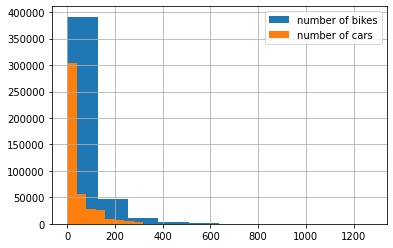

In [48]:
new_data['bike_count'].hist(label='number of bikes')
new_data['heavy_vehicules'].hist(label='number of cars')
plt.legend()

We can see that the number of bikes is higher than the number of cars in our dataset. This may be due to the fact that during the daytime the bike traffic in Paris is higher than the car traffic or this also may be due to having used different datasets (the counts may have been done differently). However, this is also not necessarily a problem because we simply want to know if there is any correlation between the quantities (regardless of the scale).

# Trying different models (simplified version)

In [49]:
from sklearn.model_selection import train_test_split

X = new_data2.loc[:, ~new_data2.columns.isin(
    ['log_bike_count'])]
Y = new_data2['log_bike_count']

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=51)

In [50]:
Y_train.shape

(364130,)

In [51]:
X_train.shape

(364130, 16)

In [52]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["year", "month", "day", "weekday", "hour"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name"]

scaling_columns = ['temperature','humidity','precipitation','cloudcover','windspeed','heavy_vehicules']

binary_columns = ['holiday', 'covid']

preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ('standard-scaler', StandardScaler(), scaling_columns)
        ]
    )

regressor = SGDRegressor()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, Y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff78dcf8550>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['site_name']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['temperature', 'humidity',
                                                   'precipitation',
                                                   'cloudcover', 'windspeed',
                                                   'heavy_vehicules'])])),
                ('sgdregressor', SGDRegressor())])

grid_result.best_estimator_

In [53]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, Y_train, cv=cv, scoring="neg_root_mean_squared_error"
)

print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.8343437  -0.83696867 -0.84179165 -0.83380893 -0.83009114 -0.84362516]
RMSE (all folds): 0.837 ± 0.00468


In [54]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

date_encoder = FunctionTransformer(_encode_dates)
date_cols = ["year", "month", "day", "weekday", "hour"]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")
categorical_cols = ["site_name"]

scaling_columns = ['temperature','humidity','precipitation','cloudcover','windspeed','heavy_vehicules']

binary_columns = ['holiday', 'covid']

preprocessor = ColumnTransformer(
        [
            ("date", OneHotEncoder(handle_unknown="ignore"), date_cols),
            ("cat", categorical_encoder, categorical_cols),
            ('standard-scaler', StandardScaler(), scaling_columns)
        ]
    )

regressor = LinearRegression()

pipe = make_pipeline(date_encoder, preprocessor, regressor)
pipe.fit(X_train, Y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function _encode_dates at 0x7ff78dcf8550>)),
                ('columntransformer',
                 ColumnTransformer(transformers=[('date',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['year', 'month', 'day',
                                                   'weekday', 'hour']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['site_name']),
                                                 ('standard-scaler',
                                                  StandardScaler(),
                                                  ['temperature', 'humidity',
                                                   'precipitation',
                                                   'cloudcover', 'windspeed',
                                                   'heavy_vehicules'])])),
                ('linearregression', LinearRegression())])

In [55]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

cv = TimeSeriesSplit(n_splits=6)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, Y_train, cv=cv, scoring="neg_root_mean_squared_error"
)

print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

RMSE:  [-0.83422936 -0.83638306 -0.84118204 -0.83358328 -0.82945651 -0.84305666]
RMSE (all folds): 0.836 ± 0.00462
